<a href="https://colab.research.google.com/github/ImanJowkar/Advanced-Regression-Method/blob/main/cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


!pip install bcolz
import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

     |████████████████████████████████| 1.5 MB 11.3 MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp37-cp37m-linux_x86_64.whl size=2647751 sha256=3628106ca564a4887546436f6cdda3f26eac5fbb42494f68111929d7f281c472
  Stored in directory: /root/.cache/pip/wheels/2c/35/ca/9d914de345914e2446ea285170329f771b8abba2a00f7650bd
Successfully built bcolz


In [2]:
use_gpu

True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/input'

%cd "/content/gdrive/MyDrive/input/cat-vs-dog"

# !pwd
# os.listdir()

# download API 
# !kaggle datasets download -d tongpython/cat-and-dog

# !unzip \*.zip && rm *.zip




Mounted at /content/gdrive
/content/gdrive/MyDrive/input/cat-vs-dog


In [4]:
# DATA_DIR = "D:/datasets/catsvsdogs/"
# DATA_DIR = "D:/datasets/catsvsdogs/dev/"
DATA_DIR = '/content/gdrive/MyDrive/input/cat-vs-dog/'
sz = 224
batch_size = 16

In [5]:
os.listdir(DATA_DIR)

['test_set', 'training_set']

In [6]:
trn_dir = f'{DATA_DIR}training_set/training_set'
val_dir = f'{DATA_DIR}test_set/test_set'

In [7]:
os.listdir(trn_dir)

['cats', 'dogs']

In [8]:
os.listdir(val_dir)

['cats', 'dogs']

In [9]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['/content/gdrive/MyDrive/input/cat-vs-dog/training_set/training_set/cats/cat.333.jpg',
 '/content/gdrive/MyDrive/input/cat-vs-dog/training_set/training_set/cats/cat.422.jpg',
 '/content/gdrive/MyDrive/input/cat-vs-dog/training_set/training_set/cats/cat.417.jpg',
 '/content/gdrive/MyDrive/input/cat-vs-dog/training_set/training_set/cats/cat.3876.jpg',
 '/content/gdrive/MyDrive/input/cat-vs-dog/training_set/training_set/cats/cat.385.jpg']

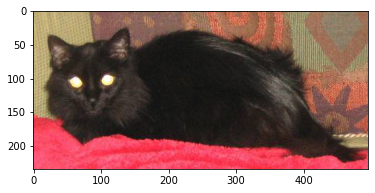

In [10]:
img = plt.imread(trn_fnames[9])
plt.imshow(img)

In [11]:
train_ds = datasets.ImageFolder(trn_dir)

In [12]:
train_ds.classes

['cats', 'dogs']

In [13]:
train_ds.class_to_idx

{'cats': 0, 'dogs': 1}

In [14]:
train_ds.root

'/content/gdrive/MyDrive/input/cat-vs-dog/training_set/training_set'

In [15]:
tfms = transforms.Compose([
                           transforms.Resize((sz, sz)), 
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                           
])

train_ds = datasets.ImageFolder(trn_dir, transform = tfms)
valid_ds = datasets.ImageFolder(val_dir, transform = tfms)

len(train_ds), len(valid_ds)

(5387, 2023)

In [16]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, 
                                       shuffle = True, num_workers = 8)


valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size = batch_size, 
                                       shuffle = True, num_workers = 8)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


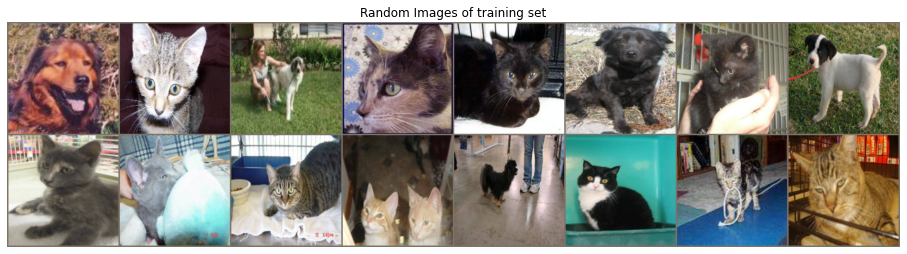

In [17]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding = 3)
plt.figure(figsize = (16, 12))
imshow(out, title = 'Random Images of training set')

# CNN Model

In [47]:
class SimpleCNN(nn.Module):
  
  
  
  def __init__(self):
    super(SimpleCNN, self).__init__()


    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 5, padding = 2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2)

    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size = 5, padding = 2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2)

    )

    self.fc = nn.Linear(56*56*32, 2)

  
  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out  

# Now, it's times to create model and put it on GPU

In [48]:
model = SimpleCNN()


In [49]:
if use_gpu:
  model = model.cuda()

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [51]:
num_epochs = 20
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [ 1/20], Step [ 50/336], Loss: 3.0010
Epoch [ 1/20], Step [100/336], Loss: 3.1180
Epoch [ 1/20], Step [150/336], Loss: 3.8562
Epoch [ 1/20], Step [200/336], Loss: 5.3018
Epoch [ 1/20], Step [250/336], Loss: 2.6486
Epoch [ 1/20], Step [300/336], Loss: 1.3209
Epoch [ 2/20], Step [ 50/336], Loss: 2.5365
Epoch [ 2/20], Step [100/336], Loss: 4.0315
Epoch [ 2/20], Step [150/336], Loss: 4.8861
Epoch [ 2/20], Step [200/336], Loss: 1.0006
Epoch [ 2/20], Step [250/336], Loss: 0.8093
Epoch [ 2/20], Step [300/336], Loss: 1.7658
Epoch [ 3/20], Step [ 50/336], Loss: 1.6027
Epoch [ 3/20], Step [100/336], Loss: 1.5154
Epoch [ 3/20], Step [150/336], Loss: 1.0249
Epoch [ 3/20], Step [200/336], Loss: 1.2165
Epoch [ 3/20], Step [250/336], Loss: 1.5400
Epoch [ 3/20], Step [300/336], Loss: 0.3647
Epoch [ 4/20], Step [ 50/336], Loss: 0.7399
Epoch [ 4/20], Step [100/336], Loss: 0.1743
Epoch [ 4/20], Step [150/336], Loss: 0.7358
Epoch [ 4/20], Step [200/336], Loss: 0.5116
Epoch [ 4/20], Step [250/336], L

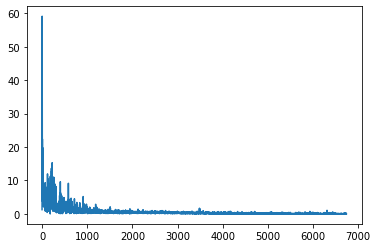

In [52]:
plt.plot(losses)

In [53]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [54]:
evaluate_model(model, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 63.12


In [55]:
evaluate_model(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 99.03


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


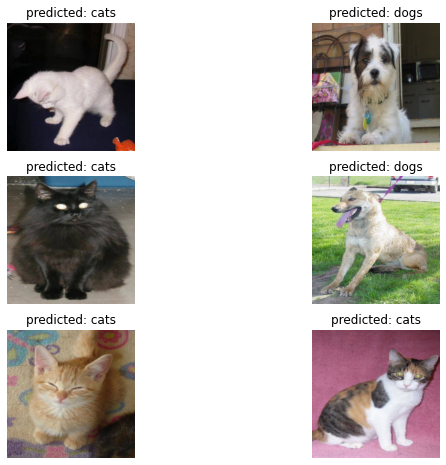

In [56]:
visualize_model(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


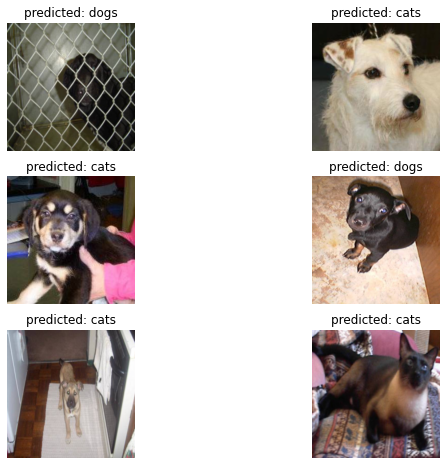

In [57]:
visualize_model(model, valid_dl)

  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 127/127 [00:13<00:00,  9.68it/s]


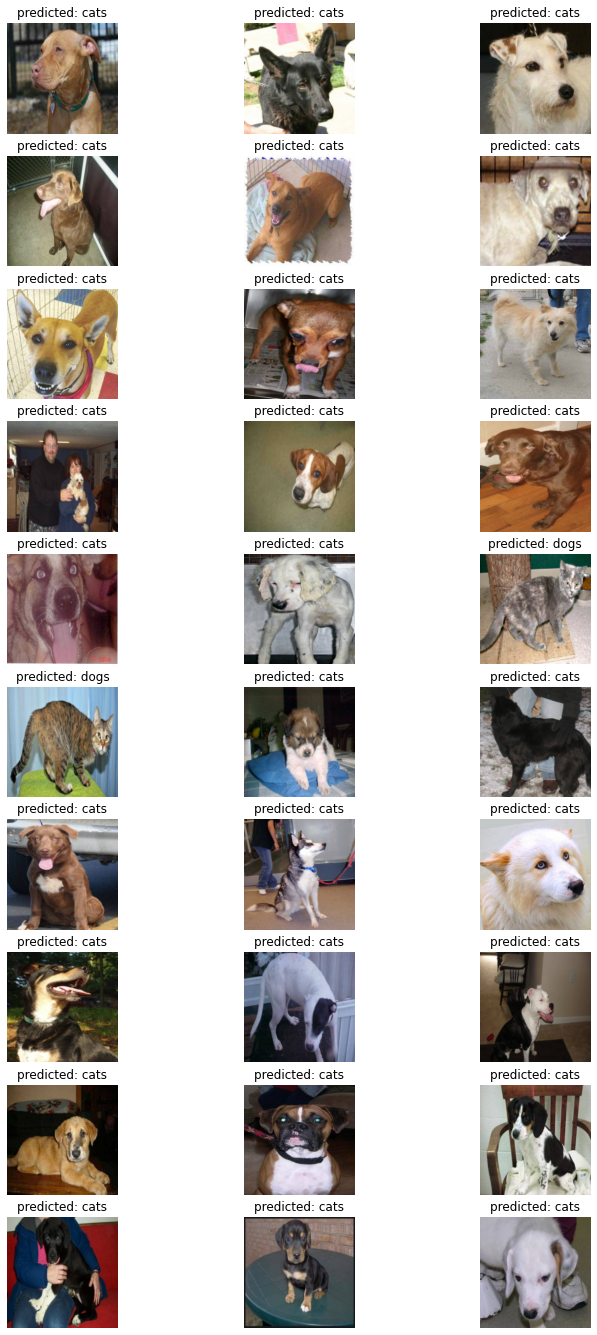

154 images out of 2023 were misclassified.


In [58]:
plot_errors(model, valid_dl)

  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 127/127 [00:12<00:00, 10.34it/s]


[[0.91 0.09]
 [0.64 0.36]]


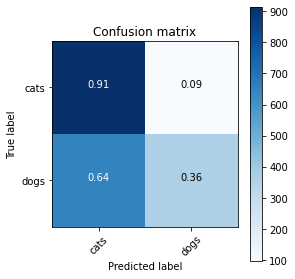

In [59]:
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))